[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238187-lesson-2-simple-graph)

# The Simplest Graph

3つのノードと1つの条件付きエッジを持つシンプルなグラフを作成してみましょう。

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State

まず、グラフの[State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)を定義します。

Stateスキーマは、グラフ内のすべてのノードとエッジの入力スキーマとして機能します。

pythonのtypingモジュールから`TypedDict`クラスをスキーマとして使用します。このクラスは、キーの型ヒントを提供します。


In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) は単なるPython関数です。

第一引数は、前述のとおり、Stateです。

前述のとおり、Stateはスキーマ付きの `TypedDict` であるため、各ノードは `state['graph_state']` でキー `graph_state` にアクセスできます。

各ノードは、状態キー `graph_state` の新しい値を返します。

デフォルトでは、各ノードが返す新しい値は、それ以前のstateの値を[上書きします](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)。





In [6]:
from typing import Any

def node_1(state) -> dict[str, Any]:
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state) -> dict[str, Any]:
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state) -> dict[str, Any]:
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) はnodeを接続します。

常に、例えば `node_1` から `node_2` に移動したい場合は、通常edgeを使用します。

[条件付きEdges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) は、node間の経路を任意で変更したい場合に利用します。

条件付きedgeは、いくつかのロジックに基づいて次に訪問するnodeを返す関数として実装されています。




In [7]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # 多くの場合、次の訪問先nodeを決定するためにstateを使用します。
    user_input = state['graph_state']

    # ここでは、ノード2とノード3の間で 0.5 対 (1-0.5) での分割を行います。
    if random.random() < 0.5:

        # 50% の確率で Node 2 を返却
        return "node_2"

    # 50% の確率で Node 3 を返却
    return "node_3"

## Graph Construction

次に、上記で定義した[コンポーネント](https://langchain-ai.github.io/langgraph/concepts/low_level/) からグラフを構築します。

[StateGraphクラス](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph)を使います。

まず、StateGraphを、上で定義した`State`クラスで初期化します。

次に、nodeとedgeを追加します。

まず、[`START` ノードという特別なノード](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node)を使用して、ユーザー入力をグラフに送信し、グラフの開始位置を指定します。

[`END` ノード](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node)は、ターミナルノードを表す特別なノードです。

最後に、[グラフをコンパイル](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph)して、グラフ構造の基本的なチェックをいくつか行います。

[Mermaid の図](https://github.com/mermaid-js/mermaid)としてグラフを視覚化することができます。

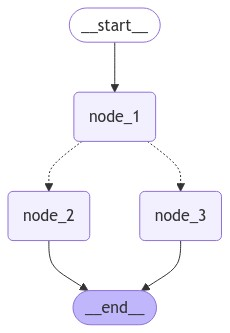

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph の起動

コンパイルされたグラフは、langchainの[runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) プロトコルを実装しています。

これにより、LangChain コンポーネントを実行するための標準的な方法が提供されます。

`invoke` は、このインターフェースの標準的なメソッドの1つです。

入力は、辞書型の `{"graph_state": "Hi, this is lance."}` であり、これはグラフのstateの辞書のための初期値を設定します。

`invoke` が呼び出されると、グラフは `START` ノードから実行を開始します。

定義済みのノード(`node_1`、`node_2`、`node_3`)を順に処理していきます。

条件付きedgeは、50対50の決定ルールを使用して、ノード `1` からノード `2` または `3` に処理します。

各ノード関数は現在の状態を受け取り、新しい値を返します。この新しい値は、グラフの状態を上書きします。

実行は、`END`ノードに到達するまで続きます。


In [9]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

`invoke` はグラフ全体を同期的に実行します。

これは、次のステップに移る前に各ステップが完了するのを待ちます。

すべてのノードが実行された後のグラフの最終状態を返します。

この場合、`node_3` が完了した後の状態を返します。

```
{'graph_state': 'Hi, this is Lance. I am sad!'}
```